<a href="https://colab.research.google.com/github/kimys0279/NCSU/blob/main/ProjC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from keras.utils import to_categorical
import numpy as np 
from numpy import mean
from numpy import std
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense, Bidirectional
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
import matplotlib.pyplot as plt

#from matplotlib import pyplotf

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

In [ ]:
# 2. Auto-iterate using the query syntax

file_list = drive.ListFile(
    {'q': "'15qCYo3QbFBwzJph5UayENRiucIjhmdM7' in parents"}).GetList()
print(file_list)
x = []
y = []
#s = {}
for f in file_list:  
  # 3. Create & download by id.
  #print('title: %s, id: %s' % (f['title'], f['id']))
  #s.append{'title: %s, id: %s' % (f['title'], f['id'])}
  fname = os.path.join(local_download_path, f['title'])
  if ('x_time' not in fname) and ('y_time' not in fname):
    #print('downloading to {}'.format(fname))
    if 'x' in fname:
      x.append(fname)
    else:
      y.append(fname)
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname, mimetype='text/csv' )
    dfx = pd.read_csv(fname, header = None)
    print(fname)
    print(dfx)

    #downloaded = drive.CreateFile({'id':f['id']}) 
    #downloaded.GetContentFile(fname, )  
  #df3 = pd.read_csv(fname, header = None)
#with open(fname, 'r') as f:
  #print(f.read())

[GoogleDriveFile({'kind': 'drive#file', 'id': '191kFhHYILdqtNsl2slJ9fqKBoU-wL4z8', 'etag': '"MTYwMjI3MTQxNTY2Ng"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/191kFhHYILdqtNsl2slJ9fqKBoU-wL4z8', 'webContentLink': 'https://drive.google.com/uc?id=191kFhHYILdqtNsl2slJ9fqKBoU-wL4z8&export=download', 'alternateLink': 'https://drive.google.com/file/d/191kFhHYILdqtNsl2slJ9fqKBoU-wL4z8/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/191kFhHYILdqtNsl2slJ9fqKBoU-wL4z8/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/text/csv', 'title': 'subject_008_01__x.csv', 'mimeType': 'text/csv', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': False}, 'copyRequiresWriterPermission': False, 'createdDate': '2020-09-30T00:57:18.125Z', 'modifiedDate': '2020-10-09T19:23:35.666Z', 'markedViewedByMeDate': '1970-01-01T00:00:00.000Z', 'version': '184', 'parents': [{'kind': 'drive#parentReference', 'id

In [ ]:
x = sorted(x)
y = sorted(y)

In [ ]:
import numpy as np
def create_dataset(X, time_steps=1, step=1):
    Xs = []
    for i in range(0, len(X), step):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [ ]:
# create sequences of size 4 and 0 overlap
for i in range(0,len(x)):
  #downloaded.GetContentFile(x[i], ) 
  dfx = pd.read_csv(x[i], header = None, skiprows = 3)
  dfy = pd.read_csv(y[i], header = None, skiprows = 1)
  x_shape = dfx.shape[0]
  y_shape = dfy.shape[0]
  #print(x_shape, y_shape, x_shape/y_shape)
  mod = x_shape % 4
  if mod != 0:
    dfx = dfx[:- mod] 
    if dfx.shape[0] < dfy.shape[0]*4: 
      dfy = dfy[:-1] 
  if i == 0:
    x_train = dfx
    y_train = dfy
  else:
    x_train = x_train.append(dfx)
    y_train = y_train.append(dfy)
  #print(dfx.shape[0], dfy.shape[0], dfx.shape[0]/dfy.shape[0])
#x_train = x_train.to_numpy()
y_train_test = y_train.values.tolist()
d = pd.Series(y_train_test).value_counts()
print(d)
y_train = y_train.to_numpy()
y_train = to_categorical(y_train)
  


[0]    251698
[3]     51609
[2]     18267
[1]     13804
dtype: int64


[0]    251698
[3]     51609
[2]     18267
[1]     13804
dtype: int64

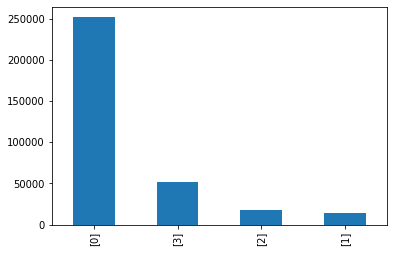

In [ ]:
ax = d.plot.bar()
d

In [ ]:
zero = d[0]
one = d[1]
two = d[2]
three = d[3]
total = zero+ one + two + three

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / zero)*(total)/4.0 
weight_for_1 = (1 / one)*(total)/4.0
weight_for_2 = (1 / two)*(total)/4.0
weight_for_3 = (1 / three)*(total)/4.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.33
Weight for class 1: 1.62
Weight for class 2: 4.59
Weight for class 3: 6.07


In [ ]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
TIME_STEPS = 4
STEP = 4
X_train= create_dataset(
    x_train,
    TIME_STEPS,
    STEP)

In [ ]:
print(X_train.shape, y_train.shape)

(335378, 4, 6) (335378, 4)


In [ ]:
# Keeping 20% for Validation
valid_set_pc = 0.2
split= int((len(X_train))*(1-valid_set_pc))

validX = X_train[split:]
validY = y_train[split:]

trainX = X_train[:split]
trainY = y_train[:split]

In [ ]:
# totaly random model to test

model = Sequential()
model.add(Bidirectional(LSTM(units=128,input_shape=[X_train.shape[1], X_train.shape[2]])))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(trainY.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    shuffle=False, class_weight=class_weight)

Epoch 1/15
9433/9433 [==============================] - 111s 12ms/step - loss: 0.7118 - acc: 0.5320 - val_loss: 1.0629 - val_acc: 0.4389
Epoch 2/15
9433/9433 [==============================] - 109s 12ms/step - loss: 0.6671 - acc: 0.4924 - val_loss: 1.1213 - val_acc: 0.3997
Epoch 3/15
9433/9433 [==============================] - 109s 12ms/step - loss: 0.6585 - acc: 0.4701 - val_loss: 1.1119 - val_acc: 0.3762
Epoch 4/15
9433/9433 [==============================] - 109s 12ms/step - loss: 0.6518 - acc: 0.4635 - val_loss: 1.1718 - val_acc: 0.3523
Epoch 5/15
9433/9433 [==============================] - 110s 12ms/step - loss: 0.6369 - acc: 0.4717 - val_loss: 1.2188 - val_acc: 0.3428
Epoch 6/15
9433/9433 [==============================] - 110s 12ms/step - loss: 0.6354 - acc: 0.4752 - val_loss: 1.1532 - val_acc: 0.3631
Epoch 7/15
9433/9433 [==============================] - 109s 12ms/step - loss: 0.6305 - acc: 0.4751 - val_loss: 1.1804 - val_acc: 0.3627
Epoch 8/15
9433/9433 [===================

In [ ]:
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:
X_train.shape[2]

6

In [ ]:
X = X_train.reshape(list(X_train.shape) + [1])    # (60000, 28, 28, 1)
X

array([[[[ 4.849308e+00],
         [ 8.411614e+00],
         [ 2.900692e+00],
         [ 2.777778e-02],
         [-1.067026e-02],
         [-1.422302e-02]],

        [[ 4.509190e+00],
         [ 8.118649e+00],
         [ 2.847298e+00],
         [ 2.157696e-02],
         [-4.549827e-02],
         [-2.111111e-02]],

        [[ 4.226515e+00],
         [ 8.273807e+00],
         [ 2.851742e+00],
         [ 1.253351e-02],
         [ 4.453396e-04],
         [-1.682951e-02]],

        [[ 4.532063e+00],
         [ 8.398341e+00],
         [ 2.856682e+00],
         [ 1.448428e-02],
         [ 2.876938e-02],
         [-1.109119e-02]]],


       [[[ 4.433669e+00],
         [ 8.294719e+00],
         [ 2.823521e+00],
         [ 1.633966e-02],
         [-2.943391e-02],
         [-8.997893e-03]],

        [[ 4.160676e+00],
         [ 8.260676e+00],
         [ 2.827568e+00],
         [ 1.122162e-02],
         [-1.674805e-02],
         [-6.026728e-03]],

        [[ 4.432763e+00],
         [ 8.272613e+00]

In [ ]:
X.shape

(335378, 4, 6, 1)

In [ ]:
# Convolutional model

model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', input_shape=(4, 6, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

#model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit network

history = model.fit(X, y_train, epochs=15, validation_split=0.1, verbose = 1)


Epoch 1/15


ValueError: ignored

In [ ]:
X_train.shape

(335378, 4, 6)

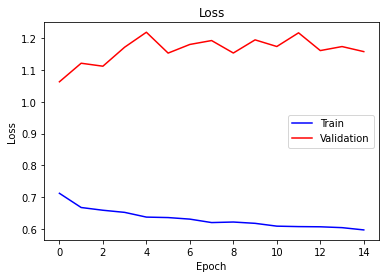

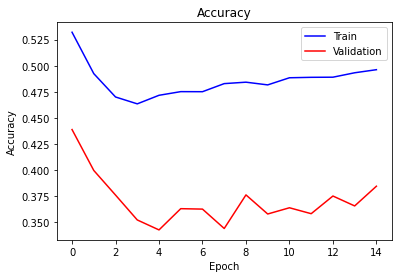

In [ ]:
plot_history(history)

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Defining Base CNN Model
def define_base_model():
  model = Sequential()
 
  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
 
  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(MaxPooling2D((2, 2)))
 
  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(MaxPooling2D((2, 2)))
 
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

# Creating an instance
base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 0, 25, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape data into time steps of sub-sequences
	n_steps, n_length = 4, 32
	#trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
	#validX = validX.reshape((validX.shape[0], n_steps, n_length, n_features))
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
	model.add(TimeDistributed(Dropout(0.5)))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(100))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
	# load data
	#trainX, trainY, validX, validY = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainY, validX, validY)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
 
# run the experiment
run_experiment()

NameError: ignored